In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import glob
import os
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

In [8]:
%matplotlib inline

# Ambient RNA

AnnData object with n_obs × n_vars = 10836 × 33538
    var: 'gene_ids', 'feature_types'


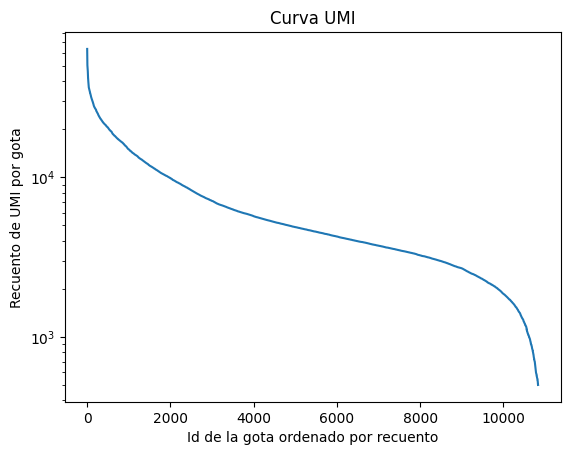

In [ ]:
adata = sc.read_10x_mtx(
    r"GSE188545_RAW\GSM5685298_HC37MTG",
    var_names="gene_symbols",
    cache=True
)
adata.write(r"GSE188545_RAW\GSM5685298_HC37MTG\GSM5685298_HC37MTG.h5ad")
print(adata)

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

ribo_adata = pd.DataFrame(adata.var['hb'])
ribo_adata = pd.DataFrame(adata.var['mt'])
ribo_adata = pd.DataFrame(adata.var['ribo'])

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

umi_counts = adata.obs["total_counts"].sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.plot(range(len(umi_counts)), umi_counts)
plt.yscale("log")
plt.xlabel("Id de la gota ordenado por recuento")
plt.ylabel("Recuento de UMI por gota")
plt.title("Curva UMI")
plt.show()

# QC integrado con todas las muestras

In [2]:
base_dir = r"GSE188545_RAW\clean_data"

adatas = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("filtered.h5"):
            adatas.append(file)

adatas

['AD02MTG_filtered.h5',
 'AD04MTG_filtered.h5',
 'AD12MTG_filtered.h5',
 'AD16MTG_filtered.h5',
 'AD17MTG_filtered.h5',
 'AD30MTG_filtered.h5',
 'HC03MTG_filtered.h5',
 'HC07MTG_filtered.h5',
 'HC14MTG_filtered.h5',
 'HC19MTG_filtered.h5',
 'HC35MTG_filtered.h5',
 'HC37MTG_filtered.h5']

In [3]:
def load_it(adata):
    samp = adata.split('_')[0]
    adata = sc.read_10x_h5(r'GSE188545_RAW\\clean_data\\' + adata)
    adata.obs['Patient'] = samp
    adata.obs.index = adata.obs.index + '-' + samp
    return adata

adatas = [load_it(ad) for ad in adatas]

def qc(adata):
    sc.pp.filter_cells(adata, min_genes = 200)
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

adatas = [qc(ad) for ad in adatas]
adatas_before = [ad.copy() for ad in adatas]

from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

clf = doubletdetection.BoostClassifier(
    n_iters=10,
    n_jobs=-1)

def pp(adata):

    cells_removed = adata.n_obs
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 20
    )

    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    cells_removed = cells_removed - adata.n_obs
    adata.uns['cells_removed'] = cells_removed

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]
    return adata

adatas = [pp(ad) for ad in adatas]
adatas_after = adatas.copy()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

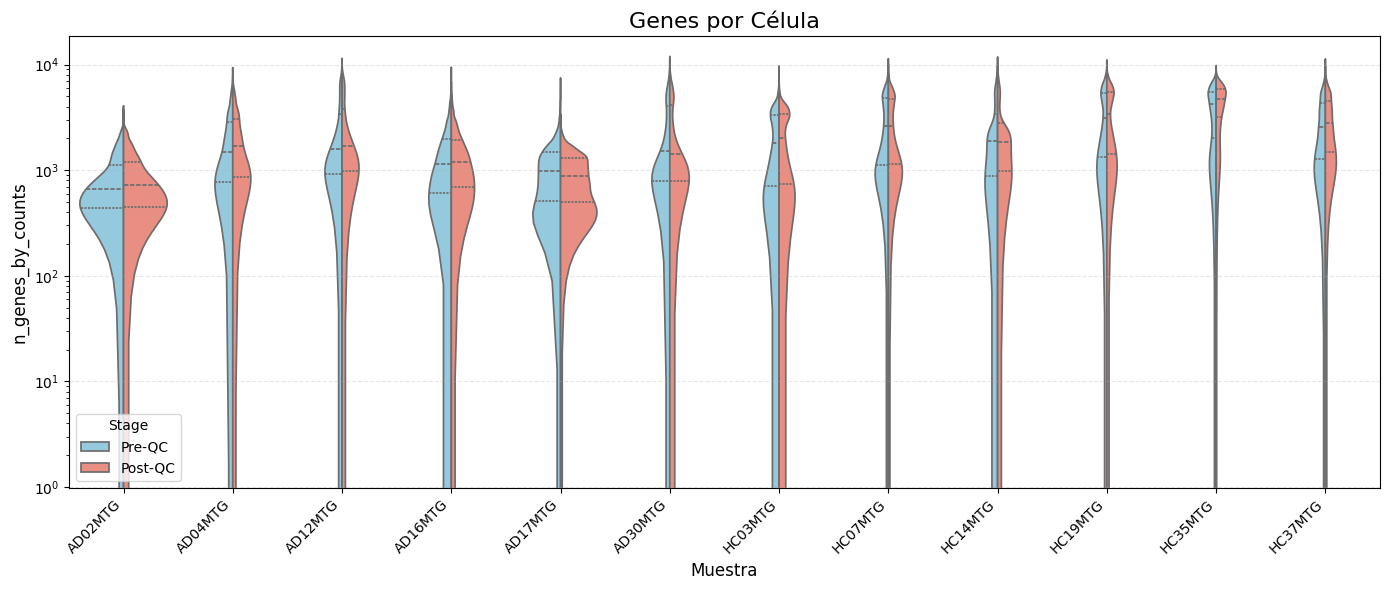

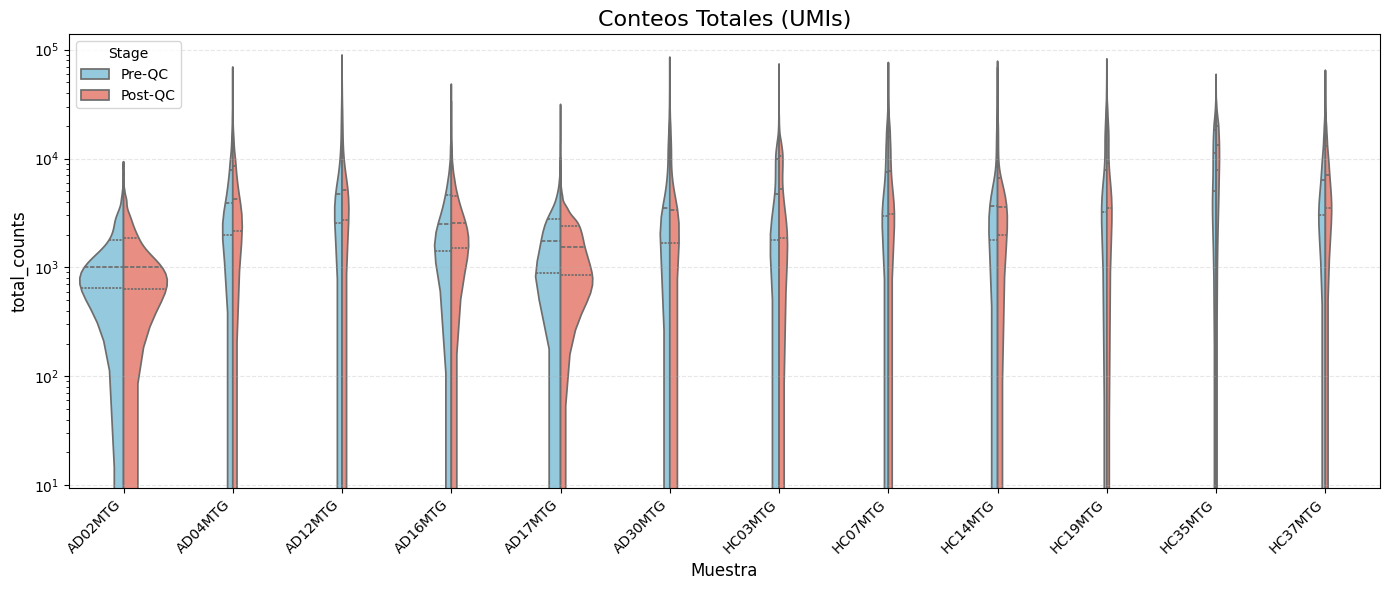

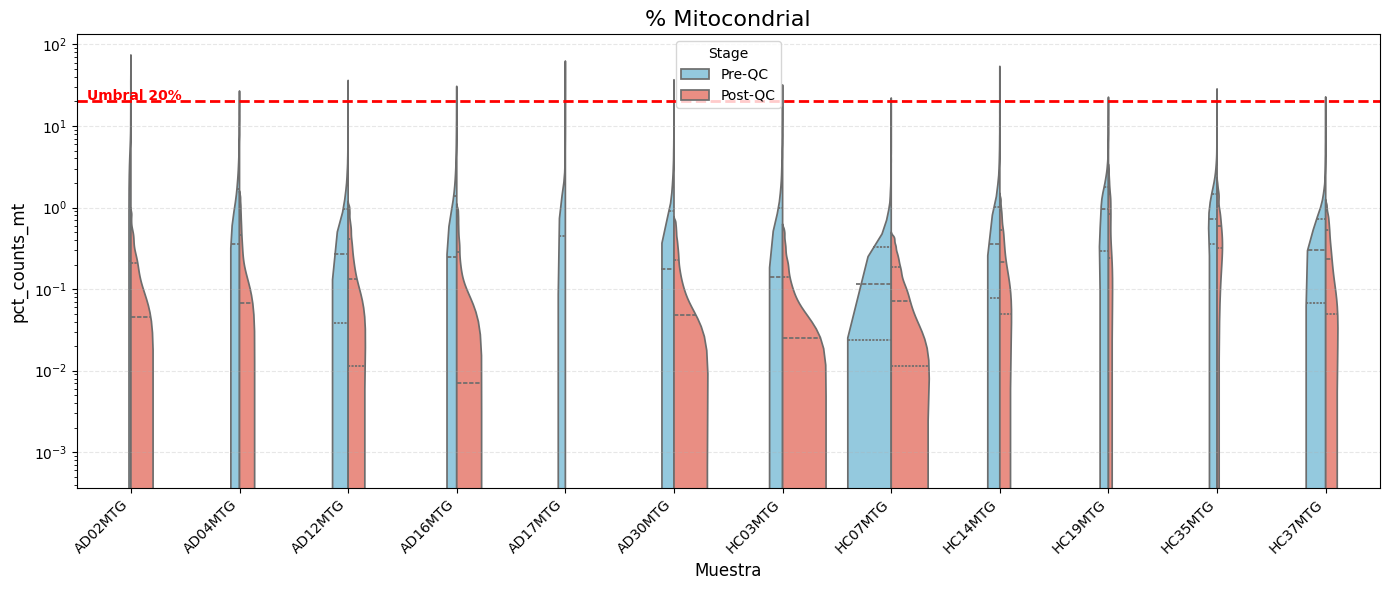

In [ ]:
def prepare_for_plotting(adatas_list, stage_label):
    temp_concat = sc.concat(adatas_list)
    df = temp_concat.obs.copy()
    df['Stage'] = stage_label
    return df

df_before = prepare_for_plotting(adatas_before, 'Pre-QC')
df_after = prepare_for_plotting(adatas_after, 'Post-QC')
df_plot = pd.concat([df_before, df_after])


metrics_info = {
    'n_genes_by_counts': {'title': 'Genes por Célula', 'log': True},
    'total_counts':      {'title': 'Conteos Totales (UMIs)', 'log': True},
    'pct_counts_mt':     {'title': '% Mitocondrial', 'log': False}
}

for metric, info in metrics_info.items():
    
    plt.figure(figsize=(14, 6))
    
    ax = sns.violinplot(
        data=df_plot,
        x="Patient",
        y=metric,
        hue="Stage",
        split=True,
        inner="quartile",
        palette={"Pre-QC": "skyblue", "Post-QC": "salmon"}
    )
    
    plt.title(info['title'], fontsize=16)
    plt.xlabel("Muestra", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.yscale('log')
        
    if metric == 'pct_counts_mt':
        plt.axhline(y=20, color='red', linestyle='--', linewidth=2)
        plt.text(x=-0.4, y=21, s='Umbral 20%', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

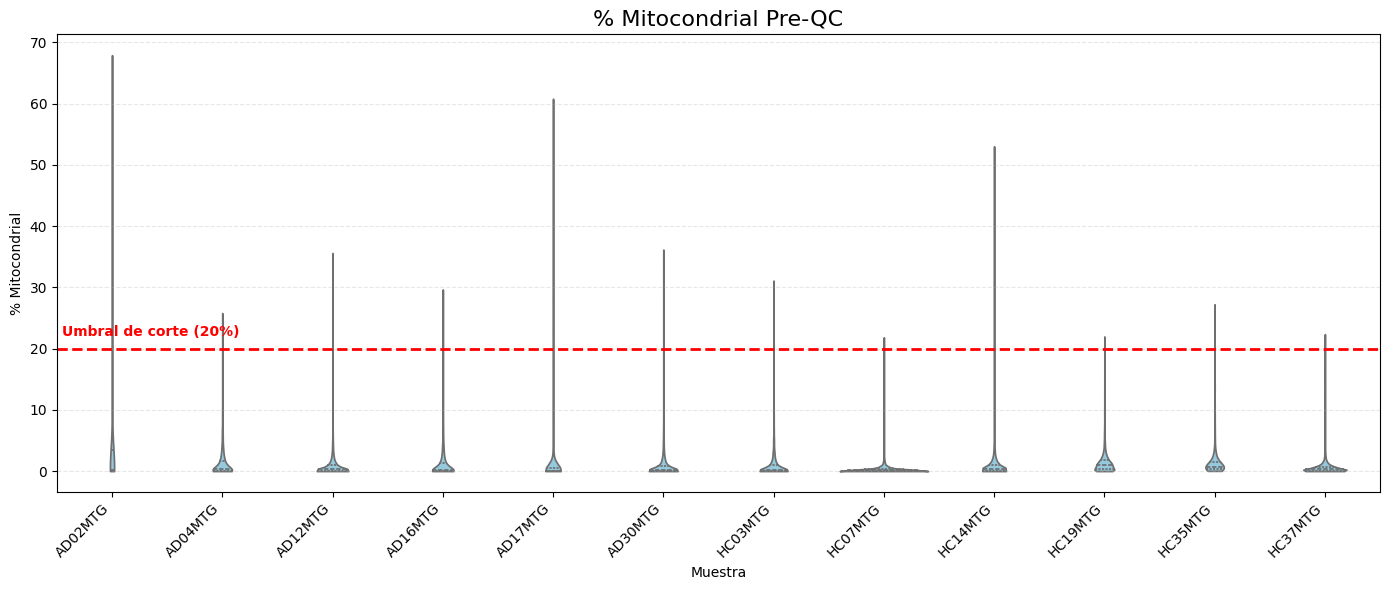

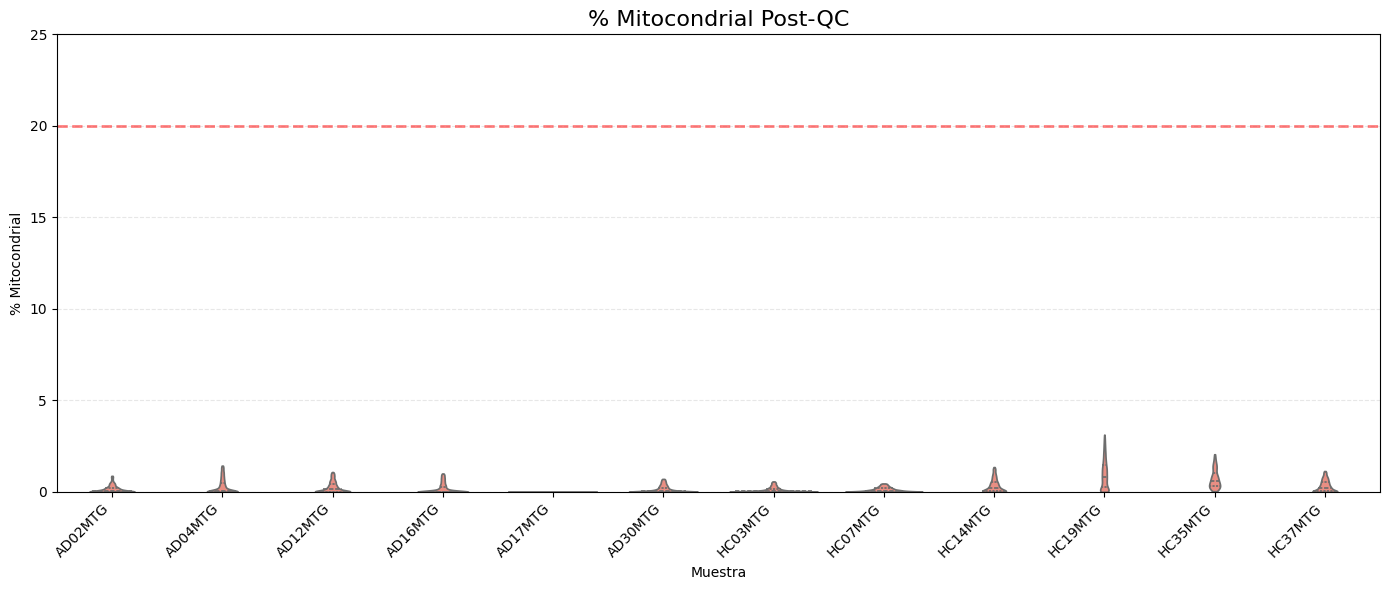

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

metric = 'pct_counts_mt'
red_line_height = 20

plt.figure(figsize=(14, 6))

data_before = df_plot[df_plot['Stage'] == 'Pre-QC']

sns.violinplot(
    data=data_before,
    x="Patient",
    y=metric,
    color="skyblue",
    inner="quartile",
    cut=0
)

plt.axhline(y=red_line_height, color='red', linestyle='--', linewidth=2)
plt.text(x=-0.45, y=red_line_height + 2, s='Umbral de corte (20%)', color='red', fontweight='bold')

plt.title('% Mitocondrial Pre-QC', fontsize=16)
plt.xlabel("Muestra")
plt.ylabel("% Mitocondrial")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

data_after = df_plot[df_plot['Stage'] == 'Post-QC']

sns.violinplot(
    data=data_after,
    x="Patient",
    y=metric,
    color="salmon",
    inner="quartile",
    cut=0
)

plt.axhline(y=red_line_height, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.title('% Mitocondrial Post-QC', fontsize=16)
plt.xlabel("Muestra")
plt.ylabel("% Mitocondrial")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, 25) 

plt.tight_layout()
plt.show()

In [24]:
import gc
del adatas_before, adatas_after
gc.collect()

93806

In [5]:
for adata in adatas:
    print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed'])

423 224 0.0
2370 1006 83.0
3664 1121 168.0
3250 1563 101.0
2318 2514 105.0
5230 2225 205.0
2744 1618 101.0
7019 1916 476.0
2899 940 176.0
6694 900 391.0
572 159 2.0
3564 690 113.0


In [16]:
for adata in adatas:
    adata.write(f"GSE188545_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")

<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_15180\3608880375.py:2: SyntaxWarning: invalid escape sequence '\{'
  adata.write(f"GSE188545_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_15180\3608880375.py:2: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE188545_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_15180\3608880375.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

# Normalization

In [ ]:
adatas = []
adatas = [sc.read(f) for f in glob.glob(os.path.join(r"GSE188545_RAW/clean_data", "*_quality_control.h5"))]

In [ ]:
for adata in adatas:
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
    #analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
    #adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adatas[0].obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adatas[0].layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_46968\195119797.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
for adata in adatas:
    adata.write(f"GSE188545_RAW\clean_data\{adata.obs['Patient'][0]}_normalization.h5")

<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_46968\651029443.py:2: SyntaxWarning: invalid escape sequence '\{'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_normalization.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_46968\651029443.py:2: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_normalization.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_46968\651029443.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

# Feature selection

In [ ]:
adatas = []
adatas = [sc.read(f) for f in glob.glob(os.path.join(r"GSE188545_RAW/clean_data", "*_normalization.h5"))]

import anndata as ad

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="sample", layer="log1p_norm")

sc.pl.highly_variable_genes(adata)

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\plotting\_utils.py:364: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
adata.write(f"GSE188545_RAW\clean_data\MATRIX_feature_selection.h5")

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_46968\1893057204.py:1: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\MATRIX_feature_selection.h5")


# Dimensionality reduction

In [15]:
%matplotlib inline

In [ ]:
adata = sc.read(r"GSE188545_RAW/clean_data/MATRIX_feature_selection.h5")
adata.X = adata.layers["log1p_norm"]

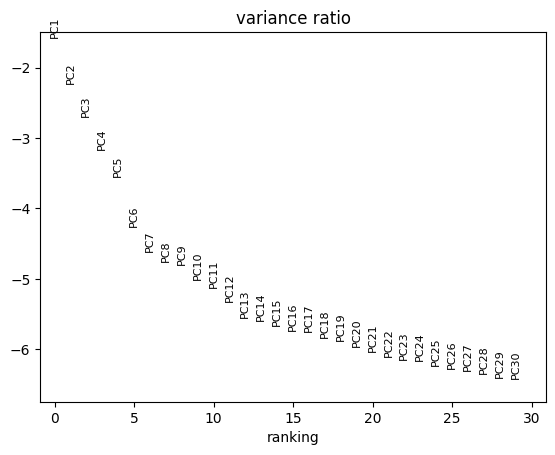

In [23]:
sc.tl.pca(adata, n_comps=30)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 30)

In [ ]:
adata.write(f"GSE188545_RAW\clean_data\MATRIX_dimensionality_reduction.h5")

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_46968\1187112096.py:1: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\MATRIX_dimensionality_reduction.h5")


# Clustering

In [ ]:
adata = sc.read(r"GSE188545_RAW/clean_data/MATRIX_dimensionality_reduction.h5")

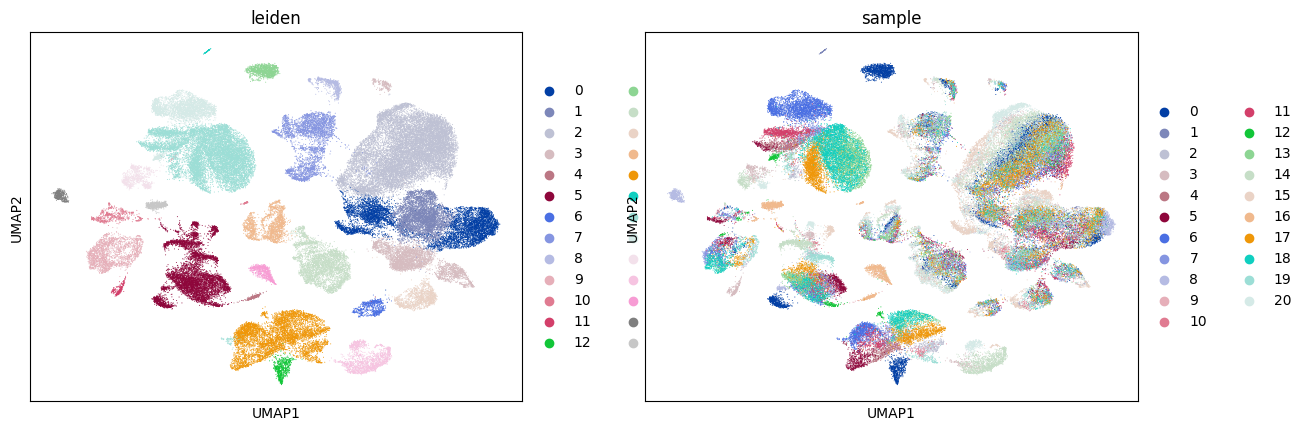

In [ ]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.25,flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=["leiden", "sample"], size=2)

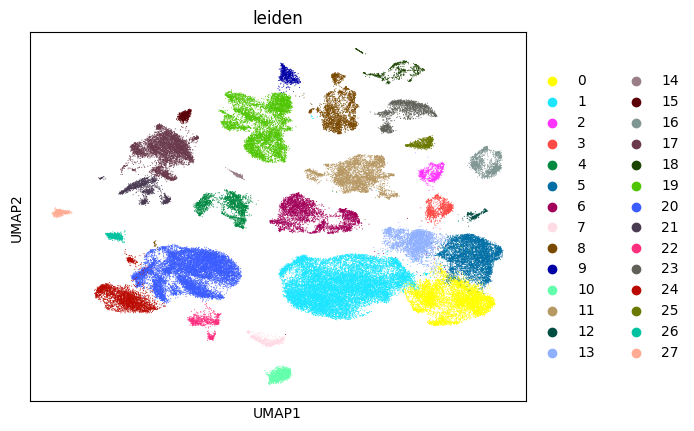

In [ ]:
sc.tl.leiden(adata, resolution=0.25,flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=["leiden"], size=2)

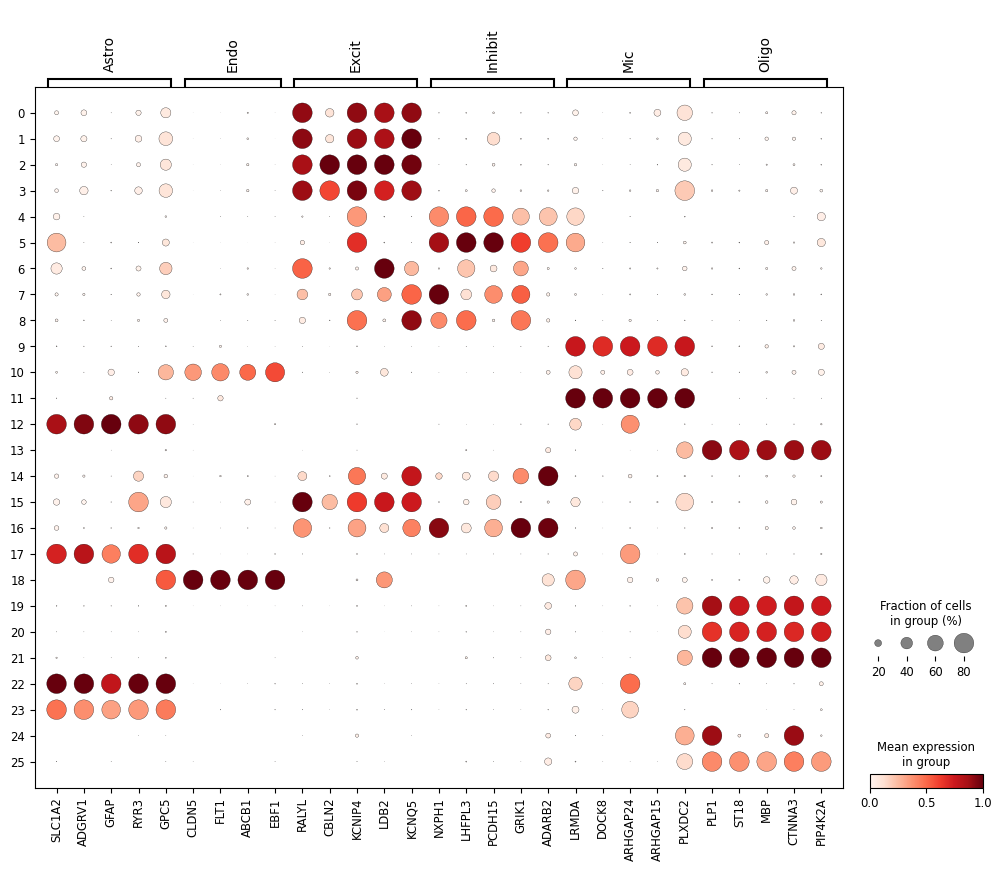

In [ ]:
marker_genes = {
    "Astro": ["SLC1A2", "ADGRV1", "GFAP","RYR3","GPC5"],
    "Endo": ["CLDN5", "FLT1", "ABCB1","EBF1"],
    "Excit": ["RALYL", "CBLN2", "KCNIP4","LDB2","KCNQ5"],
    "Inhibit": ["NXPH1","LHFPL3","PCDH15","GRIK1","ADARB2"],
    "Mic": ["LRMDA","DOCK8","ARHGAP24","ARHGAP15","PLXDC2"],
    "Oligo": ["PLP1", "ST18", "MBP","CTNNA3","PIP4K2A"],
}

marker_genes_present = {
    ct: [g for g in genes if g in adata.var_names]
    for ct, genes in marker_genes.items()
}
sc.pl.dotplot(
    adata,
    marker_genes_present,
    groupby="leiden",
    standard_scale="var",
    dot_max=0.8,
)
